In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1

In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, get_train_val_test_array
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
import os
print(os.cpu_count())
sys.setrecursionlimit(5000)



/opt/conda/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8


In [3]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())


Torch version: 1.13.1+cu117
CUDA available: True
Torch version: 1.13.1+cu117
CUDA available: True
cuDNN version: 8401


In [4]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path


import os
    


# ["ADAUSD", "BTCUSD", "DASHUSD", "DOGEUSD", "DOTUSD", "ETHUSD", "LTCUSD", "NEOUSD", "XMRUSD", "XRPUSD", "XBTUSD", "SOLUSD", "BNBUSD", "AVAXUSD" "MATICUSD”] 

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")
ada_file = Path(path_to_data + "ada.csv")
doge_file = Path(path_to_data + "doge.csv")
bnb_file = Path(path_to_data + "bnb.csv")
dot_file = Path(path_to_data + "dot.csv")
ltc_file = Path(path_to_data + "ltc.csv")
dash_file = Path(path_to_data + "dash.csv")
neo_file = Path(path_to_data + "neo.csv")
xrp_file = Path(path_to_data + "xrp.csv")
sol_file = Path(path_to_data + "sol.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

if ada_file.is_file():
    temp_df_ada_raw     = pd.read_csv(path_to_data + "ada.csv").set_index("Unnamed: 0")
else:
    temp_df_ada_raw     = lumnis.get_historical_data(factorName, "binance", "adausdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ada_raw.to_csv(path_to_data + "ada.csv")

if doge_file.is_file():
    temp_df_doge_raw     = pd.read_csv(path_to_data + "doge.csv").set_index("Unnamed: 0")
else:
    temp_df_doge_raw     = lumnis.get_historical_data(factorName, "binance", "dogeusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_doge_raw.to_csv(path_to_data + "doge.csv")

if bnb_file.is_file():
    temp_df_bnb_raw     = pd.read_csv(path_to_data + "bnb.csv").set_index("Unnamed: 0")
else:
    temp_df_bnb_raw     = lumnis.get_historical_data(factorName, "binance", "bnbusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_bnb_raw.to_csv(path_to_data + "bnb.csv")

if dot_file.is_file():
    temp_df_dot_raw     = pd.read_csv(path_to_data + "dot.csv").set_index("Unnamed: 0")
else:
    temp_df_dot_raw     = lumnis.get_historical_data(factorName, "binance", "dotusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dot_raw.to_csv(path_to_data + "dot.csv")

if ltc_file.is_file():
    temp_df_ltc_raw     = pd.read_csv(path_to_data + "ltc.csv").set_index("Unnamed: 0")
else:
    temp_df_ltc_raw     = lumnis.get_historical_data(factorName, "binance", "ltcusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ltc_raw.to_csv(path_to_data + "ltc.csv")

if dash_file.is_file():
    temp_df_dash_raw     = pd.read_csv(path_to_data + "dash.csv").set_index("Unnamed: 0")
else:
    temp_df_dash_raw     = lumnis.get_historical_data(factorName, "binance", "dashusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dash_raw.to_csv(path_to_data + "dash.csv")

if neo_file.is_file():
    temp_df_neo_raw     = pd.read_csv(path_to_data + "neo.csv").set_index("Unnamed: 0")
else:
    temp_df_neo_raw     = lumnis.get_historical_data(factorName, "binance", "neousdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_neo_raw.to_csv(path_to_data + "neo.csv")

if xrp_file.is_file():
    temp_df_xrp_raw     = pd.read_csv(path_to_data + "xrp.csv").set_index("Unnamed: 0")
else:
    temp_df_xrp_raw     = lumnis.get_historical_data(factorName, "binance", "xrpusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_xrp_raw.to_csv(path_to_data + "xrp.csv")

if sol_file.is_file():
    temp_df_sol_raw     = pd.read_csv(path_to_data + "sol.csv").set_index("Unnamed: 0")
else:
    temp_df_sol_raw     = lumnis.get_historical_data(factorName, "binance", "solusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_sol_raw.to_csv(path_to_data + "sol.csv")

# TODO: Add resample and fillna with ffill


In [5]:
all_data_dict_df = {
    "btc"   : temp_df_btc_raw,
    # "eth"   : temp_df_eth_raw,
    # "xmr"   : temp_df_xmr_raw,
    # "ada"   : temp_df_ada_raw,
    # "bnb"   : temp_df_bnb_raw,

    # "doge"  : temp_df_doge_raw,
    # "dot"   : temp_df_dot_raw,
    # "ltc"   : temp_df_ltc_raw,
    # "dash"  : temp_df_dash_raw,
    # "neo"   : temp_df_neo_raw,
    # "xrp"   : temp_df_xrp_raw,
    # "sol"   : temp_df_sol_raw
    
}

all_data_rolling_df ={}
type_rol = 'standard'

for key, value in all_data_dict_df.items():
    all_data_rolling_df[key] = rolling_mean_diff(value, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type=type_rol)

data_dict_array  = {}
max_seq_len     = 150

for key, value in all_data_rolling_df.items():
    array, array_idxs = create_3d_array(value, value.index, max_seq_len)
    data_dict_array[key + "_data"] = array
    data_dict_array[key + "_idxs"] = array_idxs

    train_array, val_array, test_array = get_train_val_test_array(array, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_data"] = train_array
    data_dict_array[key + "_val_data"] = val_array
    data_dict_array[key + "_test_data"] = test_array

    train_idxs, val_idxs, test_idxs = get_train_val_test_array(array_idxs, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_idxs"] = train_idxs
    data_dict_array[key + "_val_idxs"] = val_idxs
    data_dict_array[key + "_test_idxs"] = test_idxs

    print(train_array.shape, val_array.shape, test_array.shape)




(26968, 150, 104) (3371, 150, 104) (3372, 150, 104)


In [6]:
# from src.dataset import preprocess_sample, collate_unsuperv, noise_mask
# import multiprocessing
# def preprocess_imputation_dataset(data, mean_mask_length=3, masking_ratio=0.15,
#                  mode='separate', distribution='geometric', exclude_feats=None, max_len=None,
#                  mask_compensation=False, pad_inputs=False, mask_inputs=True):
    
#     num_workers = 1#os.cpu_count()
#     with multiprocessing.Pool(os.cpu_count()) as pool:
#         data_with_masks = list(pool.map(preprocess_sample, [(data[i], masking_ratio, mean_mask_length,
#                                                                 mode, distribution, exclude_feats)
#                                                                 for i in range(len(data))]))

#     X, targets, target_masks, padding_masks = collate_unsuperv(data_with_masks, max_len, mask_compensation,
#                                                                 pad_inputs, mask_inputs)

#     preprocessed_data = []
#     for i in range(len(data)):
#         preprocessed_sample = (X[i], targets[i], target_masks[i], padding_masks[i])
#         preprocessed_data.append(preprocessed_sample)

#     return preprocessed_data

        
# preprocessed_data = preprocess_imputation_dataset(data_dict_array["btc_train_data"])

In [7]:
# Prepare your data as a dictionary
data_dict = {}
for key in data_dict_array.keys():
    if '_train_data' in key:
        asset = key.split("_train_data")[0]
        data_dict["dataset_" + asset] = data_dict_array[key]

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
          else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

#Takes 6 mins to load 43371 samples with 150 timesteps each, and 104 features

In [7]:



input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 32
PROJECTION_DIMS         = 32

max_seq_len = 50
model_config = ModelConfig( task_name='encoder', enc_in=PROJECTION_DIMS, dec_in=PROJECTION_DIMS,  c_out=ENCODER_LAYER_DIMS,
                 d_model=64, n_heads=4, e_layers=2,  d_layers=2,  d_ff=32,
                 dropout=0.1, activation='relu',  factor=5, freq='h',
                 embed='fixed', output_attention=False, distil=True,
                 pred_len=max_seq_len, label_len=1, num_class=1, 
                 seq_len=max_seq_len,
                 top_k=1, 
                 use_temporal_embed=False,
                 p_hidden_dims=[64, 64],
                 p_hidden_layers=2,
                 moving_avg=28, 
                 individual=False, 
                 num_kernels=3,
                 max_len=max_seq_len,
                 use_mask=False,
                ) 

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )



tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST_V2",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                # type_of_encoder="non_stationary_transformer",
                                use_revin=False,
                                )

In [8]:
warmup_config_kwargs = {
    "dataset_btc": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_btc']['data'].shape[-1] if type(data_dict['dataset_btc'])==dict else data_dict['dataset_btc'].shape[-1],
        "timesteps": data_dict['dataset_btc']['data'].shape[1] if type(data_dict['dataset_btc'])==dict else data_dict['dataset_btc'].shape[1],
        "data_set_type": ImputationDataset,
        "num_epochs": 30,
        "lr": 1e-4,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_eth": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_eth']['data'].shape[-1] if type(data_dict['dataset_eth'])==dict else data_dict['dataset_eth'].shape[-1],
        "timesteps": data_dict['dataset_eth']['data'].shape[1]  if type(data_dict['dataset_eth'])==dict else data_dict['dataset_eth'].shape[1],
        "data_set_type": ImputationDataset,
        "num_epochs": 30,
        "lr": 1e-4,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_xmr": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_xmr']['data'].shape[-1] if type(data_dict['dataset_xmr'])==dict else data_dict['dataset_xmr'].shape[-1],
        "timesteps": data_dict['dataset_xmr']['data'].shape[1] if type(data_dict['dataset_xmr'])==dict else data_dict['dataset_xmr'].shape[1],
        "data_set_type": ImputationDataset,
        "num_epochs": 30,
        "lr": 1e-4,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_ada": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_ada']['data'].shape[-1] if type(data_dict['dataset_ada'])==dict else data_dict['dataset_ada'].shape[-1],
        "timesteps": data_dict['dataset_ada']['data'].shape[1] if type(data_dict['dataset_ada'])==dict else data_dict['dataset_ada'].shape[1],
        "data_set_type": ImputationDataset,
        "num_epochs": 30,
        "lr": 1e-4,
        "kwargs": {
            "verbose": False,
        }
    },
    "dataset_bnb": {
        "batch_size": 512,
        "input_channels": data_dict['dataset_bnb']['data'].shape[-1] if type(data_dict['dataset_bnb'])==dict else data_dict['dataset_bnb'].shape[-1],
        "timesteps": data_dict['dataset_bnb']['data'].shape[1] if type(data_dict['dataset_bnb'])==dict else data_dict['dataset_bnb'].shape[1],
        "data_set_type": ImputationDataset,
        "num_epochs": 30,
        "lr": 1e-4,
        "kwargs": {
            "verbose": False,
        }
    },
    # "dataset_ltc": { 
    #     "batch_size": 512,
    #     "input_channels": data_dict['dataset_ltc']['data'].shape[-1] if type(data_dict['dataset_ltc'])==dict else data_dict['dataset_ltc'].shape[-1],
    #     "timesteps": data_dict['dataset_ltc']['data'].shape[1] if type(data_dict['dataset_ltc'])==dict else data_dict['dataset_ltc'].shape[1],
    #     "data_set_type": ImputationDataset,
    #     "num_epochs": 30,
    #     "lr": 1e-4,
    #     "kwargs": {
    #         "verbose": False,
    #     }
    # },

    # "univariate": {
    #     "batch_size": 512,
    #     "input_channels": data_dict['univariate']['data'].shape[-1],
    #     "timesteps": data_dict['univariate']['data'].shape[1],
    #     "data_set_type": TSDataset,
    #     "num_epochs": 30,
    #     "lr": 1e-4,
    #     "kwargs": {
    #         "verbose": False,
    #     }
    # }
}

# TODO: Add learning rate to warmup config kwargs

N_EPOCHS                 = 50
WARMUP_EPOCHS            = 35
WARMUP_BATCH_SIZE        = 512
WARMUP_PROJECTION_LAYERS = True
BATCH_SIZE               = 512
LR                       = 1e-4
LOG                      = True

In [9]:
#TODO: - CHANGE ENCODER TYPE, - USE MORE DATA, - LOOK AT ENCODE FUNCT (are my using revin?) 

In [10]:


loss          = tsfm.fit(data_dict, n_epochs=N_EPOCHS, warmup_projection_layers=WARMUP_PROJECTION_LAYERS, 
                         log=LOG, verbose=True, shuffle=True, warmup_epochs=WARMUP_EPOCHS, 
                         warmup_config_kwargs=warmup_config_kwargs, warmup_batch_size=WARMUP_BATCH_SIZE,
                         batch_size=BATCH_SIZE, lr=LR, device=DEVICE, max_seq_length=MAX_SEQ_LENGTH, 
                        )



Total number of data points: 133622 from dataset_btc, dataset_eth, dataset_xmr, dataset_ada, dataset_bnb
Warming up with 52 batches of size 512. Dataset name dataset_btc.
Epoch: 0, Loss: 0.9579390424948472
Epoch: 1, Loss: 0.9500822046628365
Epoch: 2, Loss: 0.9370046934256187
Epoch: 3, Loss: 0.9138270582144077
Epoch: 4, Loss: 0.8825798172217149
Epoch: 5, Loss: 0.8455735926444714
Epoch: 6, Loss: 0.8068130520673898
Epoch: 7, Loss: 0.7684087352110789
Epoch: 8, Loss: 0.7300820763294513
Epoch: 9, Loss: 0.6930629014968872
Epoch: 10, Loss: 0.658109473494383
Epoch: 11, Loss: 0.6259821057319641
Epoch: 12, Loss: 0.5976645327531375
Epoch: 13, Loss: 0.5730036852451471
Epoch: 14, Loss: 0.5515064367881188
Epoch: 15, Loss: 0.5327673325171838
Epoch: 16, Loss: 0.5163019087452155
Epoch: 17, Loss: 0.5010624654017962
Epoch: 18, Loss: 0.48724626233944524
Epoch: 19, Loss: 0.47452133951278835
Epoch: 20, Loss: 0.4626724553795961
Epoch: 21, Loss: 0.45121635553928524
Epoch: 22, Loss: 0.43991481913970065
Epoch: 2

KeyboardInterrupt: 

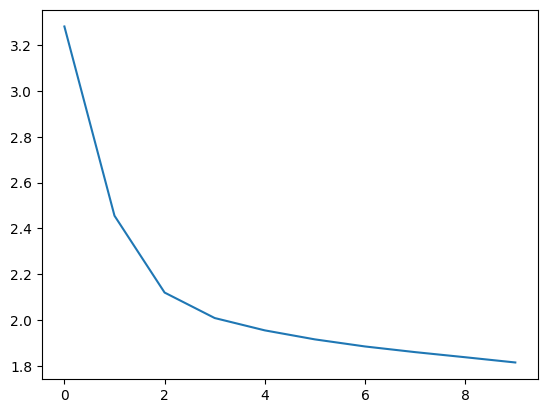

In [ ]:
for key in loss.keys():
    plt.figure()
    plt.title(key)
    plt.plot( loss[key] )
    plt.show()